# This is an attempt to learn by building and training an LLM from Scratch  

In [107]:
import os
import torch
import urllib.request

url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt" # Download a text (book)
file_path = "../data/the-verdict.txt"
if not os.path.exists(file_path):
    urllib.request.urlretrieve(url, file_path)
    
if torch.backends.mps.is_available():
    mps_device = torch.device('mps')
    # x = torch.ones(1, device=mps_device)
    # print(x)
else:
    print("mps not available")
    
    
# Now lets load the text data
with open(file_path, "r", encoding="utf-8") as f:
    raw_text = f.read() 

print("Total characters in the story: ", len(raw_text))
print("Total Lines in raw text: ", raw_text.count("\n"))
print(raw_text[:99])


Total characters in the story:  20479
Total Lines in raw text:  164
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [108]:
# Now we have to tokenize the text. The best way to do that is to use a pre-build tokennizer, but first we will try some 
# basic python regular expressions to do the same things
import re
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))
print(preprocessed[:30])

4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [109]:
# Now we need to generate token IDs
# Now let us create a list of all unique tokens and sort them alphabetically to determine the vocabulary size
all_uniq_words = sorted(set(preprocessed))
vocab_size = len(all_uniq_words)
print("Vocab size: ", vocab_size)

# Now that we know the vocabulary size, lets enumerate and assign some numbers to them
vocab = {token:integer for integer,token in enumerate(all_uniq_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 20:
        break


Vocab size:  1130
('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)


In [110]:
from src.SimpleTokenizerV1 import SimpleTokenizerV1

# Now we want to apply this vocabulary to convert new text to generate token id
# When we want to convert the outputs of an LLM from numbers back into text, we need a way to turn token IDs into text. 
# For this, we can create an inverse version of the vocabulary that maps token IDs back to the corresponding text tokens.

tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted you know," 
        Mrs Gisburn said with pardonable pride."""

ids = tokenizer.encode(text)
print(ids)
print(tokenizer.decode(ids))

[1, 56, 2, 850, 988, 602, 533, 746, 1126, 596, 5, 1, 67, 38, 851, 1108, 754, 793, 7]
" It' s the last he painted you know," Mrs Gisburn said with pardonable pride.


In [111]:
all_tokens = sorted(list(set(preprocessed))) # Make preprocessed a list so we can extend it
all_tokens.extend(["<|unk|>", "<|endoftext|>"])
# redo the vocab population
vocab = {token:integer for integer, token in enumerate(all_tokens)}
print(len(vocab.items()))


1132


In [112]:
# Print the last 5 vocab items
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|unk|>', 1130)
('<|endoftext|>', 1131)


In [113]:
from src.SimpleTokenizerV2 import SimpleTokenizerV2

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1130, 5, 355, 1126, 628, 975, 10, 1131, 55, 988, 956, 984, 722, 988, 1130, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


In [114]:
### Byte Pair Encoding 
from importlib.metadata import version
import tiktoken
print("Tiktoken version: ", version("tiktoken"))
#print("Tiktoken version: ", tiktoken.__version__)

Tiktoken version:  0.8.0


In [115]:
#### This is the tokenizer using the GPT2 tokenization model
tokenizer = tiktoken.get_encoding("gpt2")
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)
strings = tokenizer.decode(integers)
print(strings)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


In [116]:
print(tokenizer.encode("Akwirw ier"))
print(tokenizer.decode(tokenizer.encode("Akwirw ier")))

[33901, 86, 343, 86, 220, 959]
Akwirw ier


In [117]:
# Let's now do Data Sampling with a sliding window
# 1. Let's tokenize the entire story with BPE tokenizer first
with (open(file_path, "r", encoding="utf-8")) as f:
    raw_text = f.read()
    
encoded_text = tokenizer.encode(raw_text)
print(len(encoded_text))
enc_sample = encoded_text[50:]

# Now Let's start by defining x and y where x has input tokens and y the output tokens shifted by 1
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
# print(f"x: {x}")
# print(f"y:      {y}")


#####
# Next word prediction tasks can now be created by 
for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    # print(f"context input: {context} --> desired prediction: {desired}")
    # Now we create the input output target pairs
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

5145
 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [118]:
# from Dataloader import Dataloader
# 
# dataloader = Dataloader(batch_size=8, max_length=4, stride=4, shuffle=False, drop_last=True, num_workers=0)
# dataloader = dataloader.get_instance(file_path, text_enc='utf-8', mode='r')
# if dataloader is not None:
#     data_iter = iter(dataloader)
#     inputs, targets = next(data_iter)
#     print("Loaded text data...\n")
#     print("Inputs: \n", inputs)
#     print("\nTargets: \n", targets)
# else: 
#     print("Failed loading ", dataloader)


In [119]:
import torch.nn
from src.Dataloader import Dataloader
file_path = "data/the-verdict.txt"

####
# Finally we need to create the embeddings for the tokens
# If we have a batch size of 8 with 4 tokens each it'll be an 8 x 4 x 256 tensor
max_length = 4

with open("data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    

mydataloader = Dataloader(batch_size=8, max_length=max_length, stride=4, shuffle=False, drop_last=True, num_workers=0)
dataloader = mydataloader.create_dataloader_v1(txt=raw_text)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
# print("Input Token IDs:\n", inputs)
# print("Input tensor shape: ", inputs.shape) 

# Now since self-attentions are position agnostic, we should add some positional data.
# Absolute and relative positional data can be added. So let's create embeddings with say 256 dimensions
vocab_size = 50257
output_dim = 256
# context_length = 1024

## Now lets embed the input tensors
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
token_embeddings = token_embedding_layer(inputs)
print("Token embeddings shape: ", token_embeddings.shape) #8x4x256


# For a GPT model’s absolute position embedding approach, we just need to create another embedding 
# layer that has the same embedding dimension as the token_embedding_ layer:
context_length = max_length     #context is length of positions we care about for attention
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print("Positional Embeddings Shape: ", pos_embeddings.shape) # 4x256
#
# Add the positional embeddings to token embeddings
input_embeddings = token_embeddings + pos_embeddings
print("Position Merged Input Embeddings Shape: ", input_embeddings.shape)
#
# Now lets look at the dataloader
for batch in dataloader:
    inputs, targets = batch
    token_embeddings = token_embedding_layer(inputs)
    pos_embeddings = pos_embedding_layer(torch.arange(max_length))
    input_embeddings = token_embeddings + pos_embeddings
    break
#
print("Batch Embeddings Shape: ", input_embeddings.shape)
    
print("Input tensor ", x)
print("Target tensor", y)

FileNotFoundError: [Errno 2] No such file or directory: 'data/the-verdict.txt'

In [ ]:
# Chapter 3 - Attention
#
import torch

# In self-attention our goal is to calculate context vector z(i) for each 
# element x(i) of the input sequence. Consider the following input sequence 
#
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
print("Input sequence shape: ", inputs.shape)
# 
# Now calculate weights for attention
# Assume query is the second word "journey" or inputs[1] 
#
query = inputs[1]
print(f"Query is the 2nd word 'journey': {query}")
#
attention_scores_2 = torch.empty(inputs.shape[0])
for idx, x_i in enumerate(inputs):
    attention_scores_2[idx] = torch.dot(x_i, query)
#    print(f"Sequence Element [{idx}], attention_score: {attention_scores_2}")
print(f"Final value of attention_score_2: {attention_scores_2}")


In [ ]:

## Note: For all elements if we were to calculate attention it'd be a O(n^2) operation
# NOW we normalize the attention weights, so they sum up to 1
attention_weights_2_tmp = attention_scores_2 / attention_scores_2.sum()
print("Normalized attention weights:", attention_weights_2_tmp)
print("Sum of attention weights:", attention_weights_2_tmp.sum())

## Generally we normalize using the softmax to do the normalization

# # define a softmax function
def softmax_naive(tensor_x):
    return torch.exp(tensor_x) / torch.exp(tensor_x).sum(dim=0, keepdim=True)
# 
attention_scores_2_naive = softmax_naive(attention_scores_2)
print("Attention weights naive:", attention_scores_2_naive)
print ("Naive Sum: ", attention_scores_2_naive.sum())
# 
# Generally we normalize using the torch.softmax() to do the normalization
# Softmax ensures its always positive and always adds up to 1
#
attention_weights_2_torch_softmax = torch.softmax(attention_scores_2, dim=0)
print("Attention weights torch softmax:", attention_weights_2_torch_softmax)
#print("Attention weights torch softmax Sum: ", attention_weights_2_torch_softmax.sum())

# Now that we have calculated the normalized attention weights, we are ready for the final step.
# Calculate the context vector z(2) by multiplying the embedded input tokens x(i), 
# with the corresponding normalized attention weights and then summing the resultant vectors
#
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
#
for i, x_i in enumerate(inputs):
     context_vec_2 += (attention_weights_2_torch_softmax[i] * x_i)
print("Context vector z2: ", context_vec_2)
#
# Now in similar fashion lets calculate attention scores for all the input sequences 
attention_scores = torch.empty(inputs.shape[0],inputs.shape[0])
print("Attention Scores matrix shape: ", attention_scores.shape)
#
# Using for loops
#
# for i, x_i in enumerate(inputs):
#     for j, x_j in enumerate(inputs):
#         attention_scores[i, j] = torch.dot(x_i, x_j)
# #
#print(attention_scores)
#
# Using matrix multiplication we can do it faster
#
attention_scores_m = inputs @ inputs.T
#print("Normalized attention scores \n", attention_scores_m)

# Just as before lets normalize the rows, so they sum up to 1
# NOTE: Here dim = -1 means we are applying the softmax along the last dimension of the attention_scores_m tensor
#
attention_weights = torch.softmax(attention_scores_m, dim=-1)
#print("Normalized ATTENTION weights \n", attention_weights)
# print("Softmax Sums:\n", attention_weights.sum(dim=-1))

# FINAL STEP
# Now let's calculate the context vectors for all the input by multiplying the input with attention weights
all_context_vectors = attention_weights @ inputs # Matrix multiplication
#print("Context vector for the entire sequence\n", all_context_vectors)

In [ ]:

###
### 3.4.1 Using weighted matrix
###
#
# Computing the attention weights step by step
#
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2
print("x_2: ", x_2)
# Now let's initialize 3 weighted matrices Wq, Wk and Wv
# Setting requires_grad = False, to reduce clutter, but for model training this should be set to True
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
#
# Next we compute the query, key and value vectors
# Note the output is a 2 dimenstional vector because we set dout to 2
#
query_2 = x_2 @ W_query
key_2   = x_2 @ W_key
value_2 = x_2 @ W_value
print("Query 2: ", query_2)
print("Key 2:   ", key_2)
print("Value 2: ", value_2)
#
# print("\n")
#

keys = inputs @ W_key 
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
# attn_score_22 = query_2 @ keys_2
print("Attention score 22:", attn_score_22)

# Generalizing across all inputs
attn_scores_2 = query_2 @ keys.T
print("Attention Scores 2: ", attn_scores_2)
# Check the second element is same as previously calculated attention score
#
# We compute the attention weights by scaling the attention scores and using the softmax function. 
# However, now we scale the attention scores by dividing them by the square root of the embedding 
# dimension of the keys

attn_weights_2 = torch.softmax(attn_scores_2 / keys.shape[-1]**0.5, dim=-1)
print("attn_weights_2: ", attn_weights_2)

# The reason for the normalization by square root of embedding dimension size is to improve the training performance by avoiding small gradients. 
# For instance, when scaling up the embedding dimension, which is typically > 1,000 for GPT-like LLMs, large dot products can result in 
# very small gradients during backpropagation (due to the softmax function applied to them). 
# As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. 
# These small gradients can drastically slow down learning or cause training to stagnate.
#
# The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.
# Similar to when we computed the context vector as a weighted sum over the input vectors 
# we now compute the context vector as a weighted sum over the value vectors. 
# Here, the attention weights serve as a weighting factor that weighs the respective importance of each value vector
context_vec_2 = attn_weights_2 @ values
print("context_vec_2: ", context_vec_2)

In [ ]:
from src.SelfAttention_v2 import SelfAttention_v2

torch.manual_seed(789)
self_attn_v2 = SelfAttention_v2(d_in, d_out)
#print("Context vectors from SelfAtten_v2: \n", self_attn_v2(inputs))

# Note since the input contains 6 embedding vectors, the output also has 6 rows of context vectors


# Causal Attention 
# First we apply softmax to the attention scores then mask with 0 above the diagonal and then normalize the rows to 1
#
queries = self_attn_v2.W_query(inputs)
keys = self_attn_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
#print("Attention Wrights: \n",attn_weights)

# Now mask the values above diagonal as 0 using the tril() function
#
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
#print("Mask Simple: \n", mask_simple)
#
# Now simply multiply them to prevent the look ahead 
#
masked_attention_weights = attn_weights * mask_simple
#print("Masked attention weights: \n", masked_attention_weights)

#
# Now re-normalize to make sure rows add up to 1. To do this we divide each element by sum of each row
#
row_sums = masked_attention_weights.sum(dim=-1, keepdim=True)
#print("row_sums: \n", row_sums)
masked_simple_norm = masked_attention_weights / row_sums
print("Masked & re-normalized weights: \n", masked_simple_norm)

In [ ]:
# A more efficient way to obtain masked attention weights is to mask the attention scores with 
# negative infinity before applying softmax function. (e^negative infinity -> 0)
# We can implement this masking by replacing values above the diagonal with 1 and then replacing them 
# with negative infinity
#
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print("Masked attention weights: \n", masked)
#
# Now apply the softmax function 
#
attn_weights = torch.softmax(masked / keys.shape[-1] ** 0.5, dim=-1)
print("Softmax'd Attention weights: \n", attn_weights)

# Now we can use these modified attention weights to calculate the context vector
#
context_vec = attn_weights @ values
print("context_vec: \n", context_vec)

In [ ]:
# Masking additional weights with dropout
# Drop out in the attention mechanism is applied at 2 specific times: 
# 1. After calculating the attention weights
# 2. After applying the attention weights to value vectors
# Here we will apply the dropout mask after computing the attention weights
#
# Lets use a dropout rate of 50% meaning half the attention weights will be masked out. 
# Normally it's a much lower rate like 0.1 or 0.2
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(dropout(example))
#
# Since we are applying 50% dropout, to compensate for reduction in active elements
# we are going to scale up the values of remaining elements by a factor of 1/0.5 = 2
# This scaling is crucial to maintain the balance of the attention weights
#
torch.manual_seed(123)
print("Dropped out attention weights: \n", dropout(attn_weights))

In [ ]:
from src.CausalAttention import CausalAttention

# Let’s ensure that the code can handle batches consisting of more than one input so that 
# the CausalAttention class supports the batch outputs produced by the data loader
# To simulate batch input lets duplicate the input text
#
batch = torch.stack((inputs, inputs), dim=0)
print("batch: \n", batch.shape)
# print(batch)
#
# We can now use the CausalAttention class as follows
#
torch.manual_seed(123)
context_layer = batch.shape[1]
causal_attn = CausalAttention(d_in, d_out, context_length, 0.0, False)
context_vecs = causal_attn(batch)
print("context_vecs: \n", context_vecs.shape)

In [120]:
from src.MultiHeadAttentionWrapper import MultiHeadAttentionWrapper

# Multi Head Attention
# Now if we use the MultiHeadAttentionWrapper class with two attention heads, and CausalAttention 
# output dimension d_out = 2, we get a 4 dimensional context vector (d_out * num_heads = 4).
#
torch.manual_seed(123)
context_length = batch.shape[1]
d_in, d_out = 3, 2
multi_head_attn = MultiHeadAttentionWrapper(d_in, d_out, context_length, dropout=0.0, num_heads=2, qkv_bias=False)
context_vecs = multi_head_attn(batch)
print("context_vecs: \n", context_vecs)
print("context_vecs.shape: \n", context_vecs.shape)


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# import torch
# if torch.backends.mps.is_available():
#     mps_device = torch.device('mps')
#     x = torch.ones(1, device=mps_device)
#     print(x)
# else:
#     print("mps not available")

In [ ]:
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])
# print(a.transpose(2, 3))


first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

print(f"Batched: \n{a @ a.transpose(2, 3)}")

In [121]:
from src.MultiHeadAttention import MultiHeadAttention

torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
print("Batch Shape: \n", batch.shape)
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("Context vector shape: \n", context_vecs.shape)


ValueError: not enough values to unpack (expected 3, got 2)


---
## Chapter 4: Implementing GPT from Scratch to generate text

---

In [122]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

## Here is the proposed architecture and order of implementation
![image](../data/4-3.png)


In [123]:
from src.DummyGPTModel import DummyGPTModel
import tiktoken
#
torch.manual_seed(123)
#
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.clear()
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print("Input Batch: \n", batch)
#
# Next, we initialize a new 124-million-parameter DummyGPTModel instance 
# and feed it the tokenized batch
#
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape: \n", logits.shape)
#print(logits)
#                      
#

Input Batch: 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: 
 torch.Size([2, 4, 50257])


In [124]:
import torch
from torch import nn

# Let’s now implement LAYER Normalization to improve the stability and efficiency of the training.
# The main idea behind LAYER Normalization is to adjust the activations (outputs) of a deep
# neural network layer to have a mean of 0 and a variance of 1
#
# This adjustment speeds up the convergence.
#
torch.manual_seed(123)
torch.set_printoptions(sci_mode=False)
#
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print("Layer: \n",out)
#
# The NN Layer contains the non-linear activation ReLU which 0's out the negative values
# 
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean: ", mean)
print("Variance: ", var)
print("\n")
#
# Next, let’s apply layer normalization to the layer outputs we obtained earlier. 
# The operation consists of subtracting the mean and dividing by the square root 
# of the variance (also known as the standard deviation):
#
eps = 1e-5
out_norm = (out - mean) / torch.sqrt(var)
# Dim = -1 indicates statistics along the last dimention
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
torch.set_printoptions(sci_mode=True)
print("Normalized Layer Outputs: \n", out_norm)
print("Mean: \n", mean)
print("Variance: \n", var)
print("-------------------------\n")

torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)


Layer: 
 tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:  tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:  tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


Normalized Layer Outputs: 
 tensor([[6.1585e-01, 1.4126e+00, -8.7188e-01, 5.8723e-01, -8.7188e-01, -8.7188e-01],
        [-1.8865e-02, 1.1211e-01, -1.0876e+00, 1.5173e+00, 5.6474e-01, -1.0876e+00]],
       grad_fn=<DivBackward0>)
Mean: 
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000e+00],
        [1.0000e+00]], grad_fn=<VarBackward0>)
-------------------------

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [125]:
from src.LayerNorm import LayerNorm

# Previously we used unbiased = False in our variance calculation. This doesnt 
# apply Bessel's correction where divisor is n-1 instead of n. But this is 
# compatible with GPT-2

ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean: \n", mean)
print("Variance: \n", var)


Mean: 
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


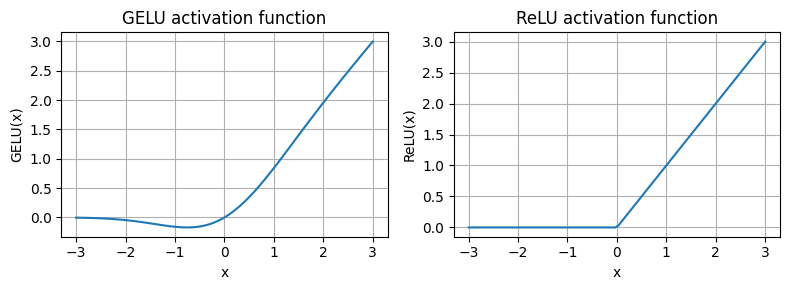

In [126]:
# Let us see how the GELU (Gaussian Error Linear Unit) stacks up against 
# # RELU (REctified Linear Unit)
from src.GELU import GELU
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [127]:
from src.SimpleFeedForward import SimpleFeedForward

# As we can see the smoothness of the GELU can lead to better optimization properties during training
# as it allows more nuanced finer adjustments to models parameters. In contrast, RELU has a sharp corner
# that can make adjustments difficult for very deep networks.
#
# Next we look at implementing a feed forward network with GELU activations
# See SimpleFeedForward.py
#
sff = SimpleFeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = sff(x)
print(out.shape)

torch.Size([2, 3, 768])


In [128]:
from src.ExampleDeepNeuralNetwork import ExampleDeepNeuralNetwork

# Next we implement Shortcut Connections
# Each layer will be initialized such that it accepts an example with three input 
# values and returns three output values.
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)


# Next lets print the gradients
def print_gradients(nnmodel, input_x):
    output = nnmodel(input_x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()
    for name, param in model.named_parameters():
        # print(name, " = ", param)
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

#
# Now Lets use this function to print the gradients calculated by loss.backward()
print_gradients(model_without_shortcut, sample_input)


AttributeError: 'NoneType' object has no attribute 'abs'

In [ ]:
# As you can see above gradients become tiny aka Vanishing from Layer4 to Layer1
# Let’s now instantiate a model with skip connections and see how it compares:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_without_shortcut, sample_input)


In [ ]:
# The gradient doesn't approach a vanishingly small value
# In conclusion, shortcut connections are important for overcoming the limitations posed 
# by the vanishing gradient problem in deep neural networks.



#### Next, we’ll connect all the previously covered concepts (layer normalization, GELU activations, feed forward module, and shortcut connections) in a transformer  block, which is the final building block we need to code the GPT architecture.

![image](../data/transformer_wiring.png)

In [ ]:
# See TransformerBlock.py for the basic wiring and feedforward details
from src.TransformerBlock import TransformerBlock

torch.manual_seed(123)
x = torch.rand(2, 4, 768)
tr_block = TransformerBlock(GPT_CONFIG_124M)
out = tr_block(x)
#
print(x.shape)
print(out.shape)
